# Assignment_1_Data_Analysis



In [37]:
import pandas as pd
import numpy as np

np.random.seed(42)
n_patients = 100
data = {
    'patient_id': range(1, n_patients + 1),
    'group': np.random.choice(['Treated', 'Never/Later Treated'], n_patients, p=[0.5, 0.5]),
    'pain_baseline': np.random.randint(0, 10, size=n_patients),
    'pain_treatment': np.random.randint(0, 10, size=n_patients),
    'pain_3months': np.random.randint(0, 10, size=n_patients),
    'pain_6months': np.random.randint(0, 10, size=n_patients),
    'urgency_baseline': np.random.randint(0, 10, size=n_patients),
    'urgency_treatment': np.random.randint(0, 10, size=n_patients),
    'urgency_3months': np.random.randint(0, 10, size=n_patients),
    'urgency_6months': np.random.randint(0, 10, size=n_patients),
    'frequency_baseline': np.random.randint(0, 10, size=n_patients),
    'frequency_treatment': np.random.randint(0, 10, size=n_patients),
    'frequency_3months': np.random.randint(0, 10, size=n_patients),
    'frequency_6months': np.random.randint(0, 10, size=n_patients),
}

df = pd.DataFrame(data)

## Risk Set Matching

In [38]:
### risk_set_matching.py
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv

def risk_set_matching(df):
    treated_patients = df[df['group'] == 'Treated']
    control_patients = df[df['group'] == 'Never/Later Treated']
    
    covariates = ['pain_baseline', 'urgency_baseline', 'frequency_baseline',
                  'pain_treatment', 'urgency_treatment', 'frequency_treatment']
    
    cov_matrix = df[covariates].cov()
    cov_matrix_inv = inv(cov_matrix)
    
    matches = []
    for _, treated in treated_patients.iterrows():
        min_distance = float('inf')
        best_match = None
        
        for _, control in control_patients.iterrows():
            if control['patient_id'] not in [match[1] for match in matches]:
                treated_vector = treated[covariates].values
                control_vector = control[covariates].values
                
                distance = mahalanobis(treated_vector, control_vector, cov_matrix_inv)
                
                if distance < min_distance:
                    min_distance = distance
                    best_match = control['patient_id']
        
        matches.append((treated['patient_id'], best_match, min_distance))
    
    return pd.DataFrame(matches, columns=['Treated Patient', 'Matched Control', 'Mahalanobis Distance'])

matched_pairs = risk_set_matching(df)
matched_pairs = matched_pairs.sort_values(by='Mahalanobis Distance')
print(matched_pairs.to_string(index=False))

 Treated Patient  Matched Control  Mahalanobis Distance
              32             18.0              0.847447
              41             89.0              1.263734
              30             92.0              1.362336
              19             26.0              1.385713
              27             29.0              1.399924
              73             46.0              1.483432
               6              3.0              1.493123
              85              2.0              1.499744
               1             88.0              1.528850
              47             71.0              1.547716
              38             74.0              1.574734
              72             55.0              1.598201
               5             95.0              1.609892
              11             66.0              1.618296
              23             34.0              1.631331
              17             10.0              1.652329
              45             76.0              1

## Integer Programming

In [39]:
import pulp
import pandas as pd

matching_problem = pulp.LpProblem("Optimal_Matching", pulp.LpMinimize)

# Drop any NaN values from matched_pairs
matched_pairs = matched_pairs.dropna()

# Convert IDs to integers
matched_pairs["Treated Patient"] = matched_pairs["Treated Patient"].astype(int)
matched_pairs["Matched Control"] = matched_pairs["Matched Control"].astype(int)

x = { (i, j): pulp.LpVariable(f"x_{int(i)}_{int(j)}", cat="Binary") 
      for i, j, _ in matched_pairs.itertuples(index=False) }

matching_problem += pulp.lpSum(
    matched_pairs.loc[(matched_pairs["Treated Patient"] == i) & (matched_pairs["Matched Control"] == j), "Mahalanobis Distance"].values[0] * x[(i, j)]
    for i, j in x
), "Total_Mahalanobis_Distance"

for i in matched_pairs["Treated Patient"].unique():
    matching_problem += (
        pulp.lpSum(x[(i, j)] for j in matched_pairs.loc[matched_pairs["Treated Patient"] == i, "Matched Control"]) == 1,
        f"Match_treated_{int(i)}"
    )

for j in matched_pairs["Matched Control"].unique():
    matching_problem += (
        pulp.lpSum(x[(i, j)] for i in matched_pairs.loc[matched_pairs["Matched Control"] == j, "Treated Patient"]) <= 1,
        f"Match_control_{int(j)}"
    )

solver = pulp.PULP_CBC_CMD(msg=False)
matching_problem.solve(solver)

final_matched_pairs = [(i, j) for i, j in x if pulp.value(x[(i, j)]) == 1]
final_matched_df = pd.DataFrame(final_matched_pairs, columns=["Treated Patient", "Control Patient"])

print(final_matched_df.to_string(index=False))

 Treated Patient  Control Patient
              32               18
              41               89
              30               92
              19               26
              27               29
              73               46
               6                3
              85                2
               1               88
              47               71
              38               74
              72               55
               5               95
              11               66
              23               34
              17               10
              45               76
              33               81
               7               36
              64               75
              43               82
              67               68
              79               28
              20               97
              50               77
              58                4
              83               56
              40               70
              

## Data Visualization

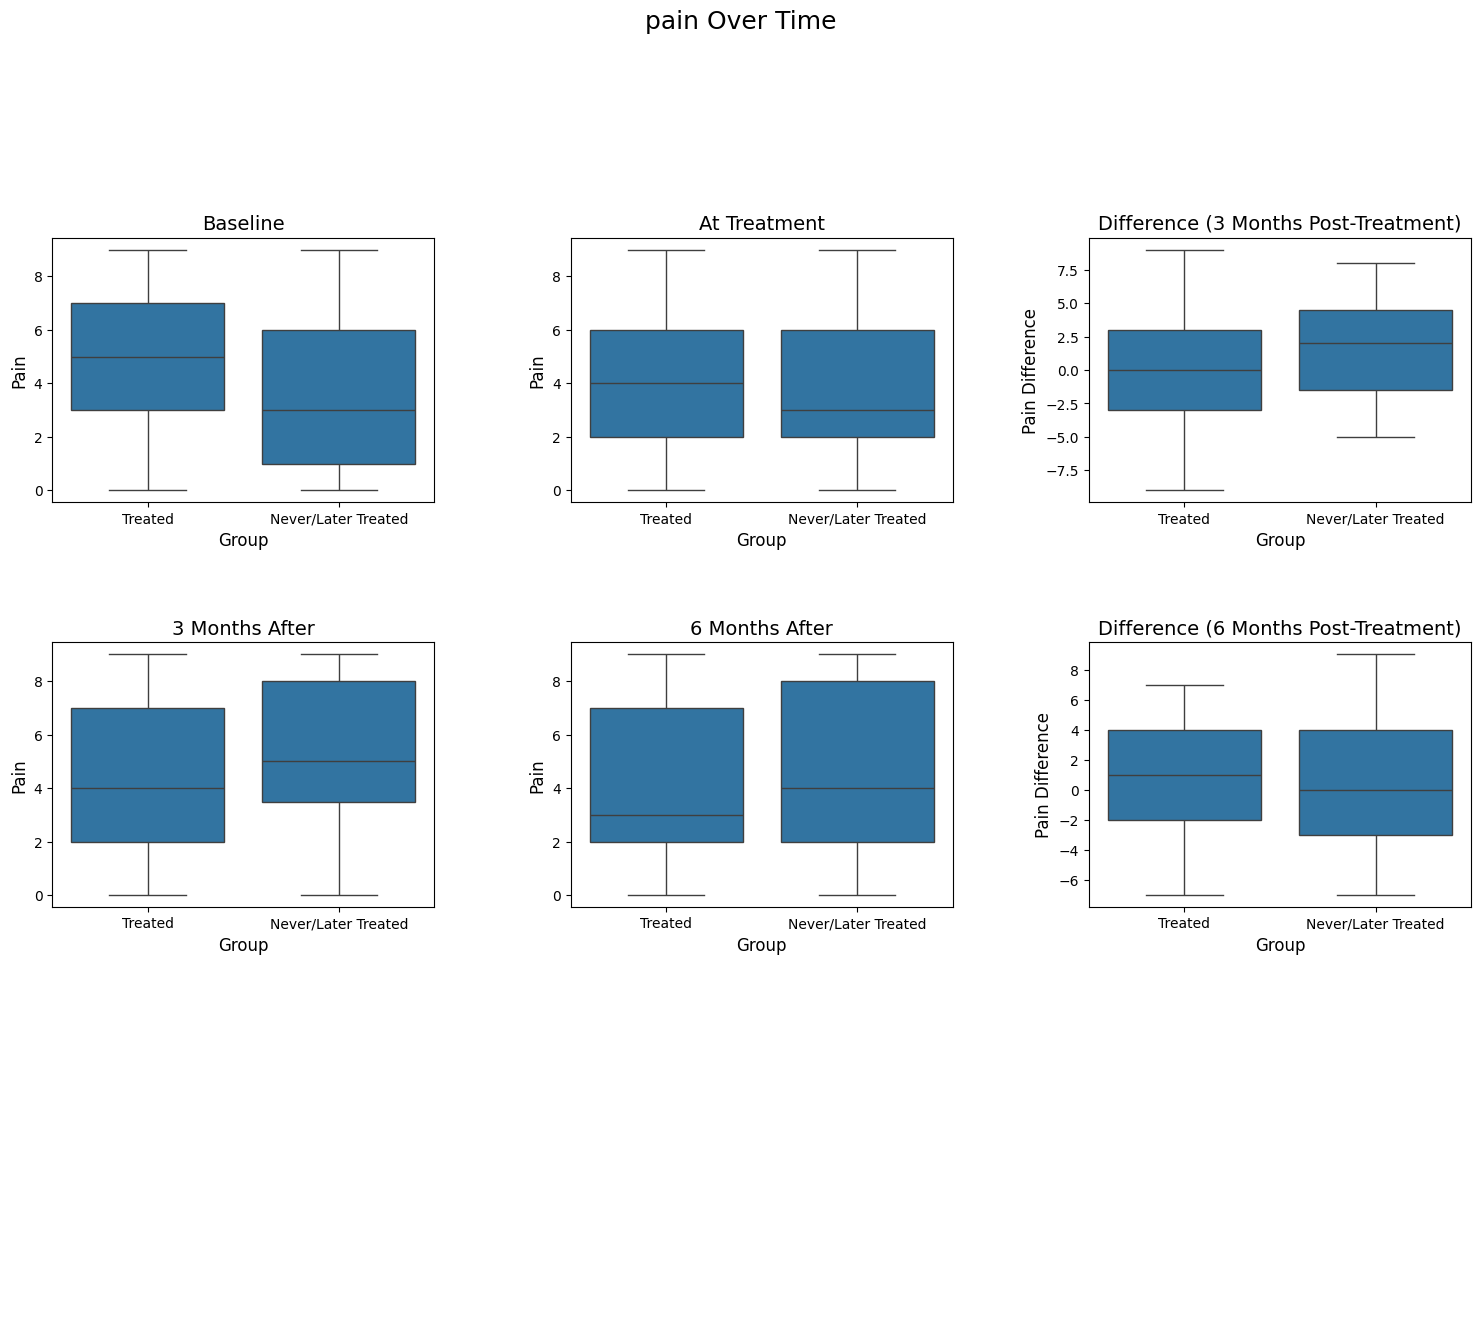

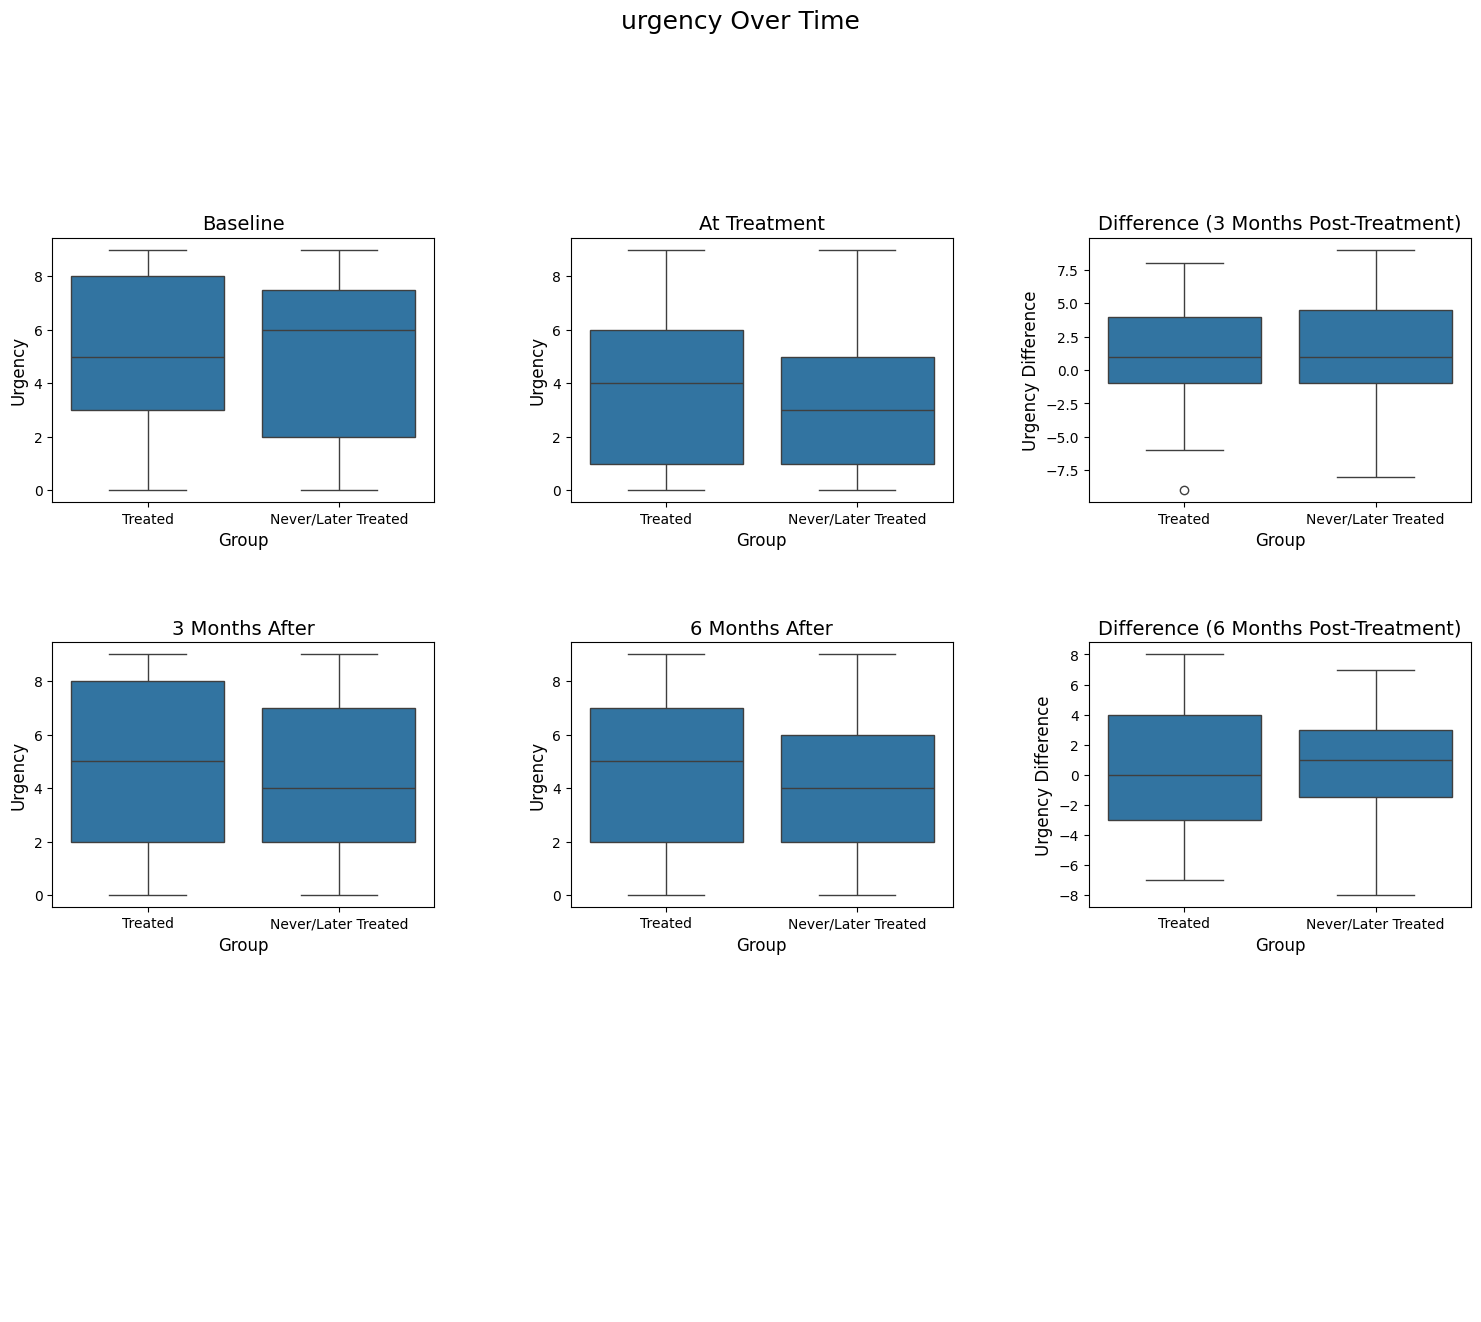

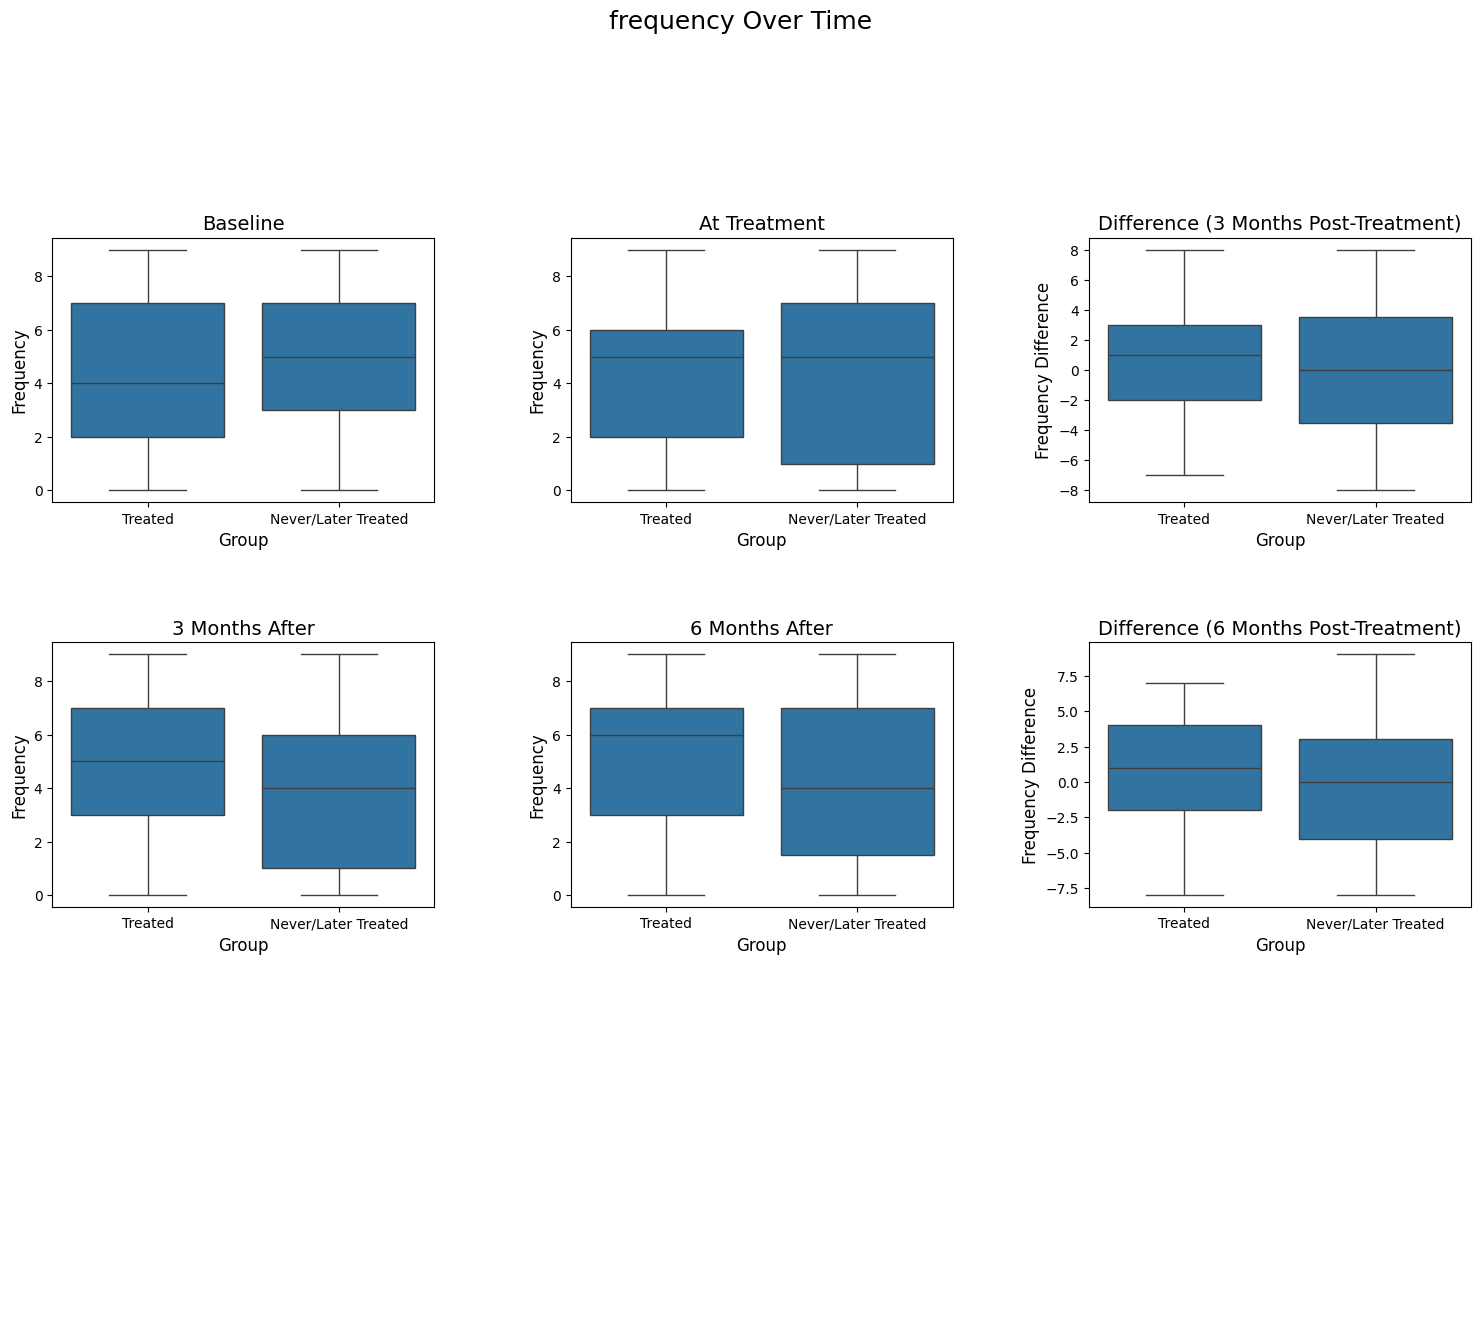

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_simplified_boxplots(df, variable):
    fig, axes = plt.subplots(3, 3, figsize=(16, 14))  # 3 rows, 3 columns
    fig.suptitle(f'{variable} Over Time', fontsize=18, y=0.98)  # Title stays in place
    
    time_points = ['baseline', 'treatment', '3months', '6months']
    titles = ['Baseline', 'At Treatment', '3 Months After', '6 Months After']
    
    # Plot the first 4 time points in the first 2 rows
    for i, time_point in enumerate(time_points):
        row = i // 2  # Determine the row (0 or 1)
        col = i % 2   # Determine the column (0 or 1)
        sns.boxplot(x='group', y=f'{variable}_{time_point}', data=df, ax=axes[row, col])
        axes[row, col].set_title(titles[i], fontsize=14)  # Keep title in place
        axes[row, col].set_ylabel(variable.capitalize(), fontsize=12)
        axes[row, col].set_xlabel('Group', fontsize=12)
    
    # Calculate differences
    df[f'{variable}_diff_3months'] = df[f'{variable}_3months'] - df[f'{variable}_treatment']
    df[f'{variable}_diff_6months'] = df[f'{variable}_6months'] - df[f'{variable}_treatment']
    
    # Plot differences in the third column
    sns.boxplot(x='group', y=f'{variable}_diff_3months', data=df, ax=axes[0, 2])
    axes[0, 2].set_title('Difference (3 Months Post-Treatment)', fontsize=14)
    axes[0, 2].set_ylabel(f'{variable.capitalize()} Difference', fontsize=12)
    axes[0, 2].set_xlabel('Group', fontsize=12)
    
    sns.boxplot(x='group', y=f'{variable}_diff_6months', data=df, ax=axes[1, 2])
    axes[1, 2].set_title('Difference (6 Months Post-Treatment)', fontsize=14)
    axes[1, 2].set_ylabel(f'{variable.capitalize()} Difference', fontsize=12)
    axes[1, 2].set_xlabel('Group', fontsize=12)
    
    # Turn off unused axes
    axes[2, 0].axis('off')
    axes[2, 1].axis('off')
    axes[2, 2].axis('off')
    
    # Adjust spacing (push lower boxplots down)
    plt.subplots_adjust(top=0.9, bottom=0.5, hspace=1.0, wspace=0.5)  # Increase hspace to push lower boxplots down
    plt.tight_layout(rect=[0, 0, 1, 0.95], pad=5)  # Prevent layout issues
    

    plt.show()

plot_simplified_boxplots(df, 'pain')
plot_simplified_boxplots(df, 'urgency')
plot_simplified_boxplots(df, 'frequency')